In [7]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
import NPL_exante as NPL
from model_zucher_exante import zurcher
from Solve_NFXP import solve_NFXP
from estimate_NFXP import estimate as NFXP_estimate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem set 5

#### 1. Look at the ReadMe.txt to get an overview of the code

#### 2. Find the formula for $P=\Lambda(V_{\sigma})$, $V_{\sigma}=\psi(P)$ and $P=\Psi(P)$, exploiting the extreme value type I distribution on $\epsilon$. 

Insert the found formulars under model_zucher_exante.psi ($V_{\sigma}=\psi(P)$) and model_zucher_exante.lambdaa ( $P=\Lambda(V_{\sigma})$)

#### 3. Solve the model using NPL, and plot the convergence of psi to check that your results are correct

<>:10: SyntaxWarning: invalid escape sequence '\P'
<>:10: SyntaxWarning: invalid escape sequence '\P'
/var/folders/dm/v2ztg7hn3_z54xvh868kqz300000gn/T/ipykernel_93473/373983611.py:10: SyntaxWarning: invalid escape sequence '\P'
  ax.set_title(f'Convergence of $\Psi$')


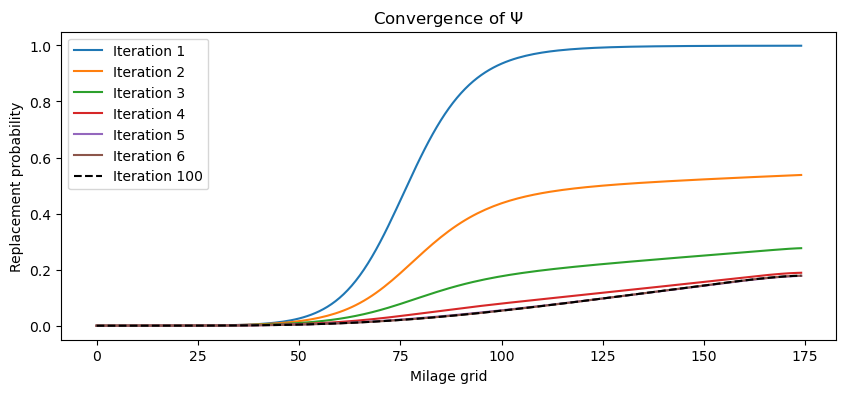

In [ ]:
# SETUP
model = zurcher()

# SOLVE THE MODEL
pk_NPL = NPL.solve(model)

fig = plt.figure(figsize=(10,4)) 
ax = fig.add_subplot(1,1,1)

ax.set_title(f'Convergence of $\Psi$')
ax.set_xlabel('Milage grid')
ax.set_ylabel('Replacement probability')
for i in range(6):
    ax.plot(model.grid,1-pk_NPL[i+1,:],label=f'Iteration {i+1}')
ax.plot(model.grid,1-pk_NPL[99,:],label=f'Iteration 100',color='black',linestyle='--')
ax.legend()
plt.show()

#### 4. Now you have to compare NFXP and NPL. Remeber that NFXP solve the fixed-point problem in value function space ( EV = Γ( EV ) ) and NPL solves it in CCP space ( pk = Ψ( pk ) ). Calculate the CCPs from either method and compare the results

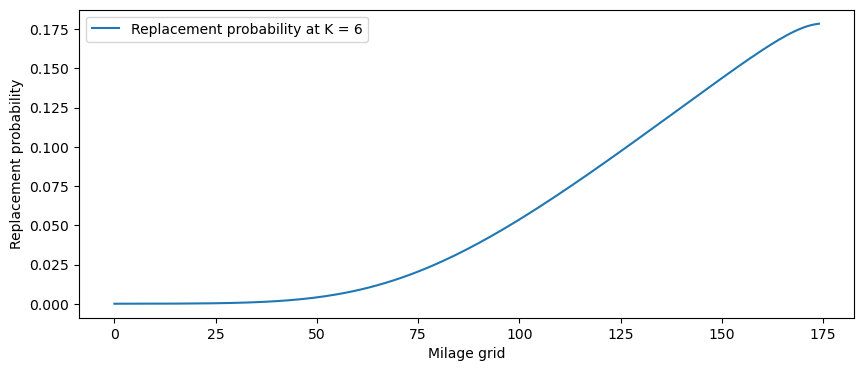

In [20]:
# solve the model with NFXP
ev0 = np.zeros(model.n)
solver_NFXP = solve_NFXP()
_, pk_NFXP = solver_NFXP.poly(model.bellman, ev0, beta=model.beta, output=2)


# Define figure
fig = plt.figure(figsize=(10,4)) 
ax = fig.add_subplot(1,1,1)



ax.plot(model.grid,1-pk_NPL[6,:],label='Replacement probability at K = 6')
ax.plot(model.grid,1-pk_NPL[99,:],label=r'Last evaluation of $\Psi$')
ax.plot(model.grid,1-pk_NFXP,label=r'Fixed point of $\Gamma$ (NFXP)')

ax.set_xlabel('Milage grid')
ax.set_ylabel('Replacement probability')
plt.legend()

plt.show()

NPL runtime: 0.1523 sec, iterations: 100
NFXP runtime: 0.0151 sec
Max absolute difference (NPL vs NFXP): 3.985701e-13


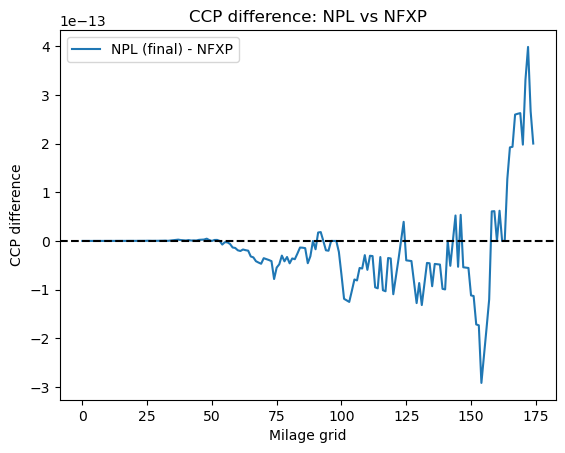

In [23]:
import time
# Setup
model = zurcher()

# --- NPL ---
start_npl = time.time()
pk_NPL = NPL.solve(model)  # Expected shape: (n_iter, n_grid)
npl_time = time.time() - start_npl
npl_iter = pk_NPL.shape[0]

# --- NFXP ---
ev0 = np.zeros(model.n)
start_nfxp = time.time()
_, pk_NFXP = solver_NFXP.poly(model.bellman, ev0, beta=model.beta, output=2)
nfxp_time = time.time() - start_nfxp

# --- Difference analysis ---
max_diff = np.max(np.abs(pk_NPL[-1, :] - pk_NFXP))

# --- Print summary ---
print(f"NPL runtime: {npl_time:.4f} sec, iterations: {npl_iter}")
print(f"NFXP runtime: {nfxp_time:.4f} sec")
print(f"Max absolute difference (NPL vs NFXP): {max_diff:.6e}")

# --- Plot CCP differences ---
plt.plot(model.grid, pk_NPL[-1, :] - pk_NFXP, label='NPL (final) - NFXP')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Milage grid')
plt.ylabel('CCP difference')
plt.title('CCP difference: NPL vs NFXP')
plt.legend()
plt.show()


#### 5. $F^{U}(pk)$ is the unconditional transition probabilities induced by pk (vector) - what does that mean? 
(a) How does it differ from the transition matrices P.

The matrix $F^{U}(pk)$ is the the unconditional transition matrix, which represents the probabilities of transitioning between states when individuals follow some given decision rule by a vector of conditional choice probabilities, CCP. This is referred to as $pk$. 

In context of Rust's bus engine model, the decision rule captures the probability of choosing the action 'keep' in each milage state. They key distinction between $F^{U}(pk)$ and the transition matrices P lies in the conditioning. The model specifies two conditional transition matrices: 
- $P_1$ - Describing transition conditional decision to keep the current engine 
- $P_2$ - Describing transition conditional decision to replace the current engine 
These matrices represent the physical evolution of the state variable, which in this case is milage, under each discrete choice. 

But now, $F^{U}(pk)$ is not conditional on a specific decision but instead refelcts the average behavior across the population, given their probabilistic decision-making encoded in $pk$. This is constructed as a convex combination of the two conditional matrices. 
$$F^{U}(pk)=diag(pk)\cdot P_1+diag(1-pk)\cdot P_2$$
This weigthed sum captures the fact that, in each state, the agent chooses to 'keep' with some probability, $pk$ and to replace with $1-pk$. Therefore, the $F^{U}(pk)$ reflects the actual observed transitions in the data, given the agents behave stochastically according to $pk$. 

The transitions matrices $P_1$ and $P_2$ describe how the state, in this case, milage changes depending on whether the agent chooses to keep or replace the engine. These are fixed by the model and do not depend on the agent's behavior

In contrast, the matrix 
F
U
(
p
k
)
F 
U
 (pk) is built using the actual behavior of the agent, as described by the choice probabilities 
p
k
pk. It combines 
P
1
P 
1
​	
  and 
P
2
P 
2
​	
  based on how likely the agent is to choose each action in every state. This means that 
F
U
(
p
k
)
F 
U
 (pk) reflects what happens on average, given the decisions the agent makes in equilibrium.

#### 6. What determines if NFXP is computationally cheaper to use than NPL? Think about what is in the inner loop of either algorithm. 

#### 7. Now we have to Estimate the model using NPL. In order to estimate the model you should understand 
<il type ="a">
<li> NPL.estimate </li>
<li> NPL.ll (skip the part of computing the gradient and the Hessian)</li>
</il>

#### 8. Fill in the missing stuff in NPL.ll, and run the code below to check that your results are correct

In [ ]:
 # ESTIMATE
# setup
Kmax=10  # Max number of outer loop iterations for NPL 
pnames = ['RC','c']
model = zurcher()

# Load data
data = model.read_busdata(bustypes=[1,2,3,4])
data_class = NPL.setup_data(data)
samplesize = data_class.x.size

#Estimate using NPL
import time
t0 = time.time()
res, theta_hat,pk = NPL.estimate(model, data_class, Kmax)
t1 = time.time()

# Print the results
print(f'Structual estimation using busdata from Rust(1987)')
print(f'Beta        = {model.beta:.4f}')
print(f'n           = {model.n}')
print(f'Sample size = {samplesize}')

print('\n \nNPL \n--------------------------------')
print(f'Parameters     Estimates    s.e. ') 
print(f'{pnames[0]}             {theta_hat[0]:.4f}     ')
print(f'{pnames[1]}              {theta_hat[1]:.4f}      \n ')


print(f'Log-likelihood {-res.fun*samplesize:.4f}') 
print(f'runtime (seconds) {(t1-t0):.4f}')

# Estimate using NFXP
theta0 = (0.,0.)
solver_NFXP = solve_NFXP()
t0 = time.time()
nfxp_model, optim_res, pnames, theta_hat, Avar, converged=NFXP_estimate(model, solver_NFXP,data,theta0=theta0, twostep=0)

t1 = time.time()
time = t1-t0

# Print the result
print('\n \nNFXP \n--------------------------------')
print(f'Parameters     Estimates    s.e. ') 
print(f'{pnames[0]}             {theta_hat[0]:.4f}     {np.sqrt(Avar[0,0]):.4f} ')
print(f'{pnames[1]}              {theta_hat[1]:.4f}     {np.sqrt(Avar[1,1]):.4f} \n ')

print(f'Log-likelihood {-optim_res.fun*samplesize:.2f}') 
print(f'runtime (seconds) {time:.4f}')